In [1]:
import pandas as pd
import numpy as np
import mne
import scipy.signal as signal
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt

import sys
sys.path.append('../src/utils')
from load_data import load_trial, load_metadata, get_dataset_split# type: ignore

In [2]:
base_path = '../data'
metadata = load_metadata(base_path)

In [3]:
train = metadata['train']

In [4]:
first_eeg = load_trial(train.iloc[0, :], 'train', base_path)
first_eeg.head()

,Time,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,AccX,AccY,AccZ,Gyro1,Gyro2,Gyro3,Battery,Counter,Validation
0,471108.629297,259145.062500,255463.203125,280156.78125,297592.40625,268555.25000,255108.156250,232334.953125,239896.906250,-0.156006,0.782959,-0.566162,-10.437011,6.835937,13.610839,93.333344,405287.0,1.0
1,471108.634537,259071.937500,255626.625000,282968.28125,297913.18750,269795.59375,255109.765625,232506.515625,240036.203125,-0.143799,0.778809,-0.562500,-9.582519,6.866455,13.305663,93.333344,405288.0,1.0
2,471108.634549,259450.296875,255598.296875,283131.25000,297802.50000,269435.43750,255080.796875,232323.593750,239907.625000,-0.137451,0.773926,-0.560303,-9.185790,7.019042,13.183593,93.333344,405289.0,1.0
3,471108.636824,259770.734375,255431.093750,280456.65625,297436.09375,267998.68750,255079.453125,232064.765625,239711.656250,-0.133545,0.770508,-0.560303,-8.483886,7.385253,12.847899,93.333344,405290.0,1.0
4,471108.639355,259562.062500,255346.515625,278669.31250,297312.09375,267488.87500,255097.703125,232085.765625,239713.000000,-0.132324,0.774902,-0.561523,-7.568359,7.873535,12.390136,93.333344,405291.0,1.0


In [5]:
def get_bad_mask(df, acc_thresh=15, gyro_thresh=5, battery_thresh=15):
    acc = df[['AccX', 'AccY', 'AccZ']].values
    gyro = df[['Gyro1', 'Gyro2', 'Gyro3']].values
    acc_mag = np.linalg.norm(acc, axis=1)
    gyro_mag = np.linalg.norm(gyro, axis=1)

    return (
        (acc_mag > acc_thresh) |
        (gyro_mag > gyro_thresh) |
        (df['Battery'].values < battery_thresh) |
        (df['Validation'].values == 0)
    )

In [6]:
from itertools import groupby
from operator import itemgetter

def plot_trial_with_annotations(row, fs=250, max_channels=8):
    """
    Plots EEG channels + accel norm + gyro norm + validation.
    Highlights bad samples using vertical lines.
    
    Parameters:
        eeg_dict: dict from load_trial() — contains 'eeg', 'acc', 'gyro', 'validation'
        bad_mask: boolean array of shape (time,) where True = bad sample
        fs: sampling frequency (default: 250Hz)
        max_channels: number of EEG channels to plot (for clarity)
    """
    eeg_data = load_trial(row, 'train', base_path)
    bad_mask = get_bad_mask(eeg_data)
    
    eeg = eeg_data.iloc[:, 1:9].values.T
    acc = eeg_data.iloc[:, 9:12].values.T
    gyro = eeg_data.iloc[:, 12:15].values.T
    val = eeg_data.iloc[:, -1].values

    time = np.arange(eeg.shape[1]) / fs
    acc_norm = np.linalg.norm(acc, axis=0)
    gyro_norm = np.linalg.norm(gyro, axis=0)

    n_channels = min(max_channels, eeg.shape[0])
    fig, axs = plt.subplots(n_channels + 3, 1, figsize=(15, 2 * (n_channels + 3)), sharex=True)

    # EEG channels
    for ch in range(n_channels):
        axs[ch].plot(time, eeg[ch], label=f'EEG ch{ch+1}')
        axs[ch].set_ylabel(f'Ch {ch+1}')
        axs[ch].legend(loc='upper right')
        axs[ch].grid(True)

    # Acc norm
    axs[n_channels].plot(time, acc_norm, color='orange', label='Accel norm')
    axs[n_channels].set_ylabel('Accel')
    axs[n_channels].legend(loc='upper right')
    axs[n_channels].grid(True)

    # Gyro norm
    axs[n_channels + 1].plot(time, gyro_norm, color='purple', label='Gyro norm')
    axs[n_channels + 1].set_ylabel('Gyro')
    axs[n_channels + 1].legend(loc='upper right')
    axs[n_channels + 1].grid(True)

    # Validation
    axs[n_channels + 2].plot(time, val, color='green', label='Validation flag')
    axs[n_channels + 2].set_ylabel('Valid')
    axs[n_channels + 2].legend(loc='upper right')
    axs[n_channels + 2].grid(True)

    # Bad sample markers
    bad_indices = np.where(bad_mask)[0]

    # Group contiguous bad indices into regions
    bad_groups = []
    for k, g in groupby(enumerate(bad_indices), lambda ix: ix[0] - ix[1]):
        group = list(map(itemgetter(1), g))
        bad_groups.append((group[0], group[-1]))

    # Highlight regions
    for ax in axs:
        for start, end in bad_groups:
            ax.axvspan(start/fs, end/fs, color='red', alpha=0.2)

        axs[-1].set_xlabel('Time (s)')
    plt.suptitle(f"EEG Trial: {row['subject_id']} | Task: {row['task']} | Session: {row['trial_session']} | Trial: {row['trial']}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

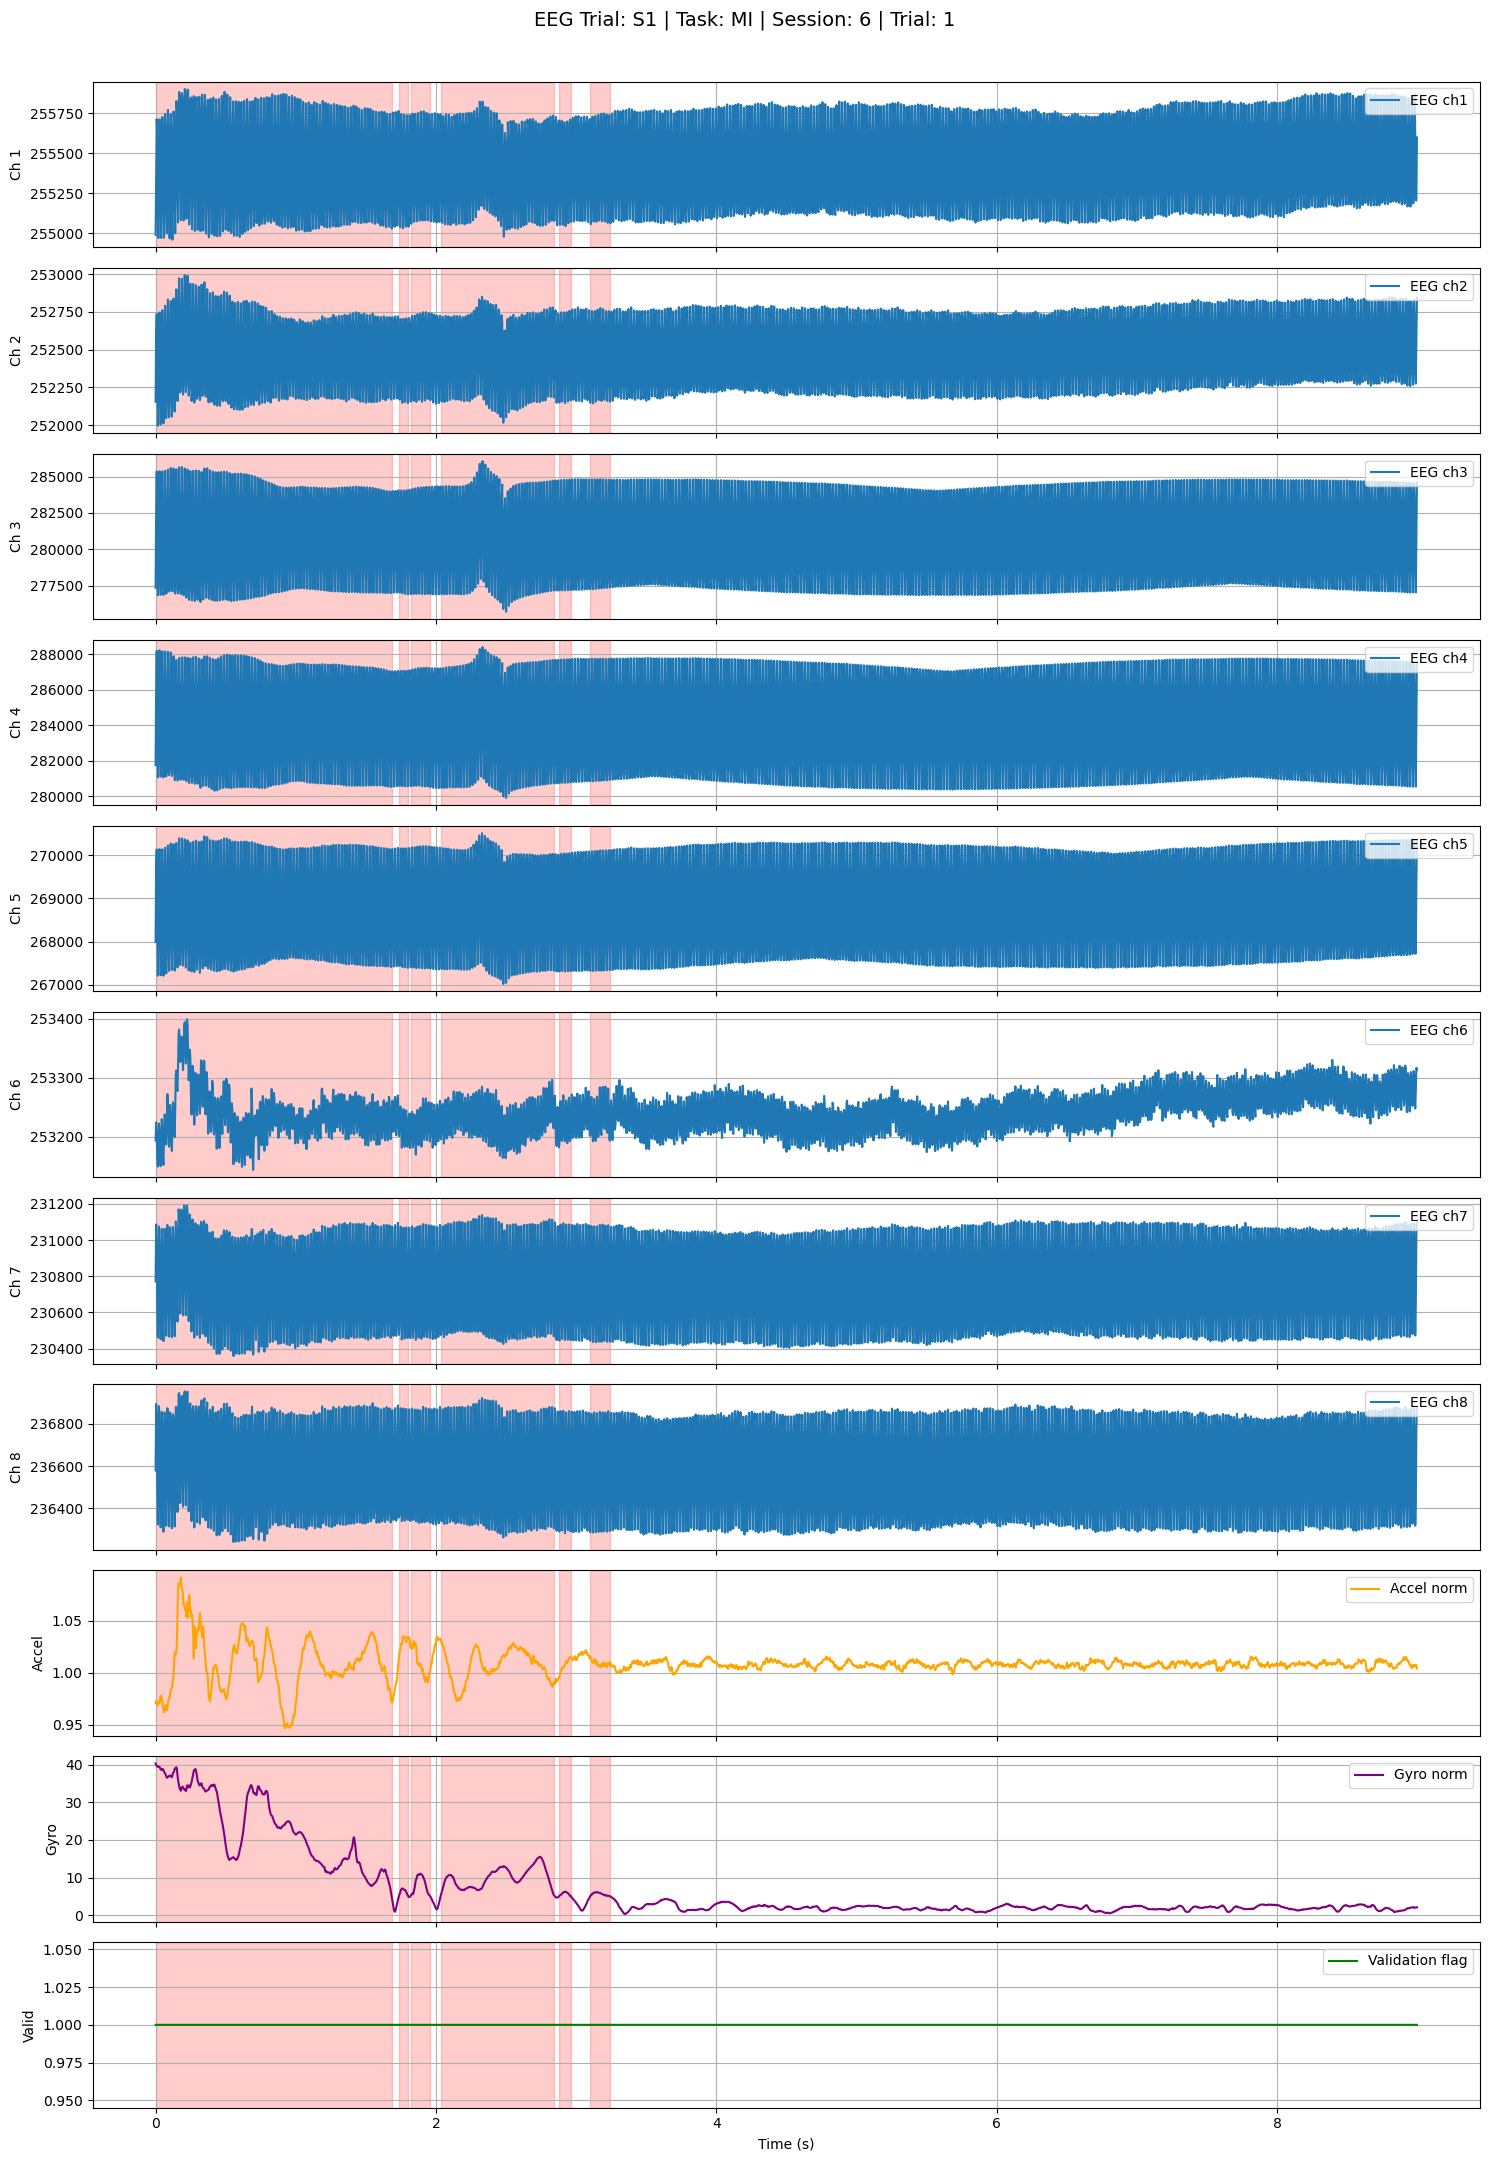

In [7]:
plot_trial_with_annotations(train.iloc[50, :])

In [8]:
def preprocess_eeg_trial(row, use_case='time_domain', fs=250,
                         interpolation_kind='linear',
                         window_size_sec=2, stride_sec=0.5):
    """
    Preprocess EEG data for modeling or feature extraction.
    
    Parameters:
        eeg_dict (dict): Dictionary with keys 'eeg', 'acc', 'gyro', etc.
        bad_mask (ndarray): Boolean mask of shape (time,) indicating bad timepoints.
        use_case (str): One of 'time_domain', 'frequency_domain', or 'deep_learning'.
        fs (int): Sampling frequency in Hz.
        interpolation_kind (str): 'linear', 'nearest', etc.
        window_size_sec (float): Size of clean window (in seconds) for 'time_domain'.
        stride_sec (float): Stride (in seconds) between windows.
        
    Returns:
        Depending on use_case:
            - List of clean windows (time/frequency)
            - Preprocessed raw EEG for deep learning
            - Optional mask for deep learning
    """
    eeg_data = load_trial(row, 'train', base_path)
    bad_mask = get_bad_mask(eeg_data)
    eeg = eeg_data.iloc[:, 1:9].values.T  # shape (channels, time)

    if use_case == 'time_domain':
        # Remove windows with any bad samples
        return extract_clean_windows(eeg, bad_mask, window_size_sec, stride_sec, fs)

    elif use_case == 'frequency_domain':
        # Interpolate bad samples to maintain continuity
        eeg_clean = interpolate_bad_samples(eeg, bad_mask, kind=interpolation_kind)
        return eeg_clean

    elif use_case == 'deep_learning':
        # Interpolate or zero out and provide a mask
        eeg_interp = interpolate_bad_samples(eeg, bad_mask, kind=interpolation_kind)
        mask = (~bad_mask).astype(float)  # 1 for good, 0 for bad
        return eeg_interp, mask  # mask shape (time,)

    else:
        raise ValueError(f"Unknown use_case: {use_case}")
    
def interpolate_bad_samples(eeg, bad_mask, kind='linear'):
    eeg_clean = eeg.copy()
    time = np.arange(eeg.shape[1])
    for ch in range(eeg.shape[0]):
        good_idx = ~bad_mask
        if np.sum(good_idx) < 2:
            # Not enough points to interpolate
            eeg_clean[ch, bad_mask] = 0
            continue
        interp = interpolate.interp1d(
            time[good_idx], eeg[ch, good_idx], kind=kind, fill_value='extrapolate'
        )
        eeg_clean[ch, bad_mask] = interp(time[bad_mask])
    return eeg_clean

def extract_clean_windows(eeg, bad_mask, window_size_sec, stride_sec, fs):
    win_len = int(window_size_sec * fs)
    stride = int(stride_sec * fs)
    segments = []
    for start in range(0, eeg.shape[1] - win_len + 1, stride):
        end = start + win_len
        if not bad_mask[start:end].any():
            segments.append(eeg[:, start:end])
    return segments

In [9]:
def plot_eeg_channels(eeg_data, fs=250, channel_names=None, figsize=(12, 10)):
    """
    Plot EEG channels on separate axes.

    Parameters:
        eeg_data (ndarray): EEG array of shape (num_channels, samples)
        fs (int): Sampling frequency in Hz
        channel_names (list): Optional list of channel names
        figsize (tuple): Figure size for the plot
    """
    num_channels, num_samples = eeg_data.shape
    time = np.arange(num_samples) / fs

    if channel_names is None:
        channel_names = [f"Ch {i+1}" for i in range(num_channels)]

    fig, axs = plt.subplots(num_channels, 1, figsize=figsize, sharex=True)

    for i in range(num_channels):
        axs[i].plot(time, eeg_data[i])
        axs[i].set_ylabel(channel_names[i])
        axs[i].grid(True, linestyle='--', alpha=0.3)

    axs[-1].set_xlabel("Time (s)")
    fig.suptitle("EEG Channels", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

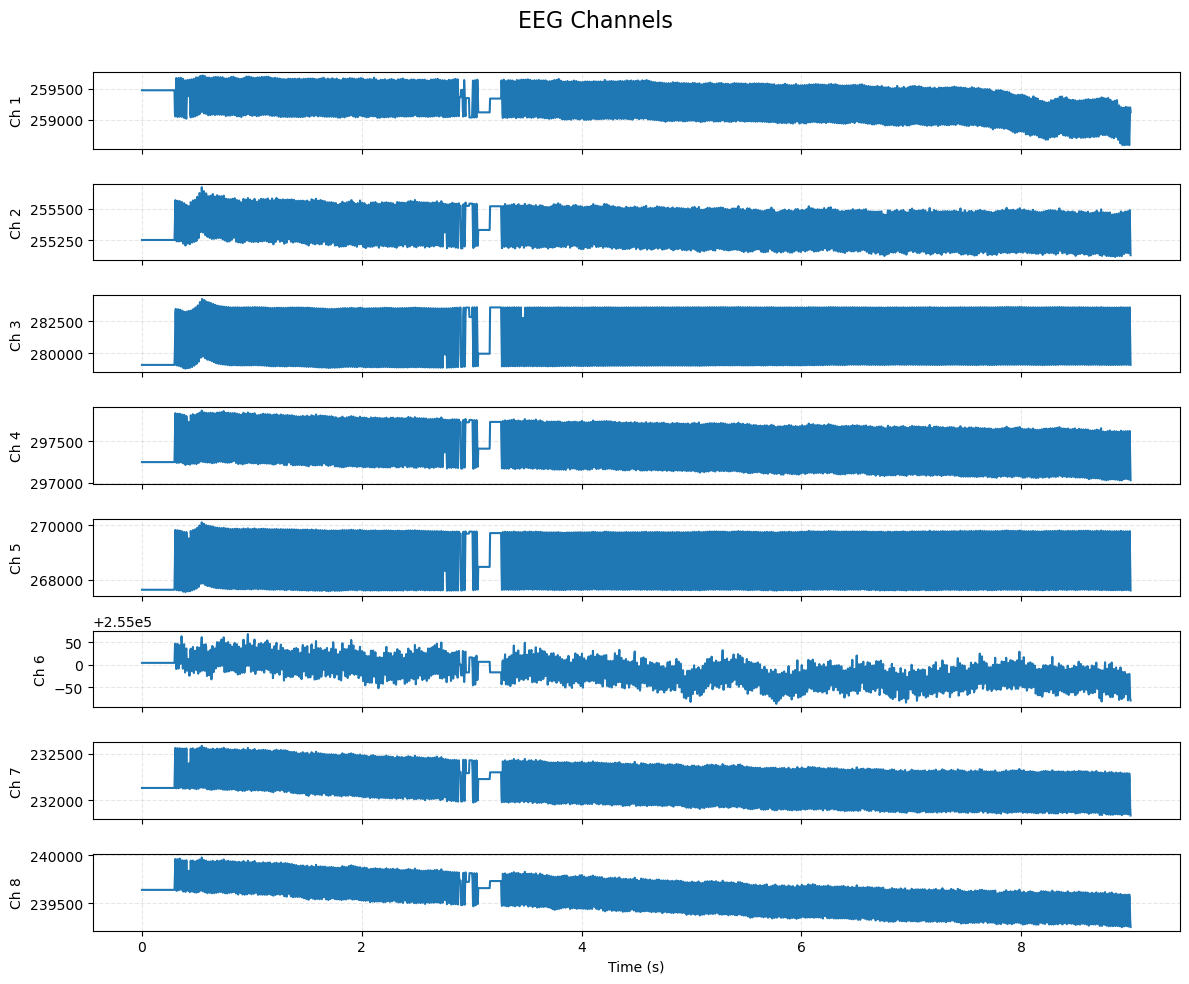

In [10]:
cleaned_eeg = np.array(preprocess_eeg_trial(train.iloc[0, :], use_case='frequency_domain', interpolation_kind='nearest', window_size_sec=2, stride_sec=0.5))
plot_eeg_channels(cleaned_eeg, fs=250)

In [ ]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = fs / 2
    b, a = signal.butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return signal.filtfilt(b, a, data, axis=1)

def remove_dc_offset(data):
    return data - np.mean(data, axis=1, keepdims=True)

def standardize(data):
    return (data - np.mean(data, axis=1, keepdims=True)) / (np.std(data, axis=1, keepdims=True) + 1e-8)

def clip_extremes(data, threshold=5):
    return np.clip(data, -threshold, threshold)

In [12]:
def preprocess_time_domain(eeg_data, fs=250, lowcut=1, highcut=45, downsample_to=None, clip_thresh=None):
    """
    Preprocess EEG data for time-domain feature extraction.
    """
    # General preprocessing
    eeg = remove_dc_offset(eeg_data)
    eeg = bandpass_filter(eeg, lowcut, highcut, fs)
    if clip_thresh is not None:
        eeg = clip_extremes(eeg, threshold=clip_thresh)
    # eeg = standardize(eeg)
    
    if downsample_to is not None and downsample_to < fs:
        num_samples = int(eeg.shape[1] * downsample_to / fs)
        eeg = signal.resample(eeg, num_samples, axis=1)
        fs = downsample_to
    
    return np.array(eeg), fs

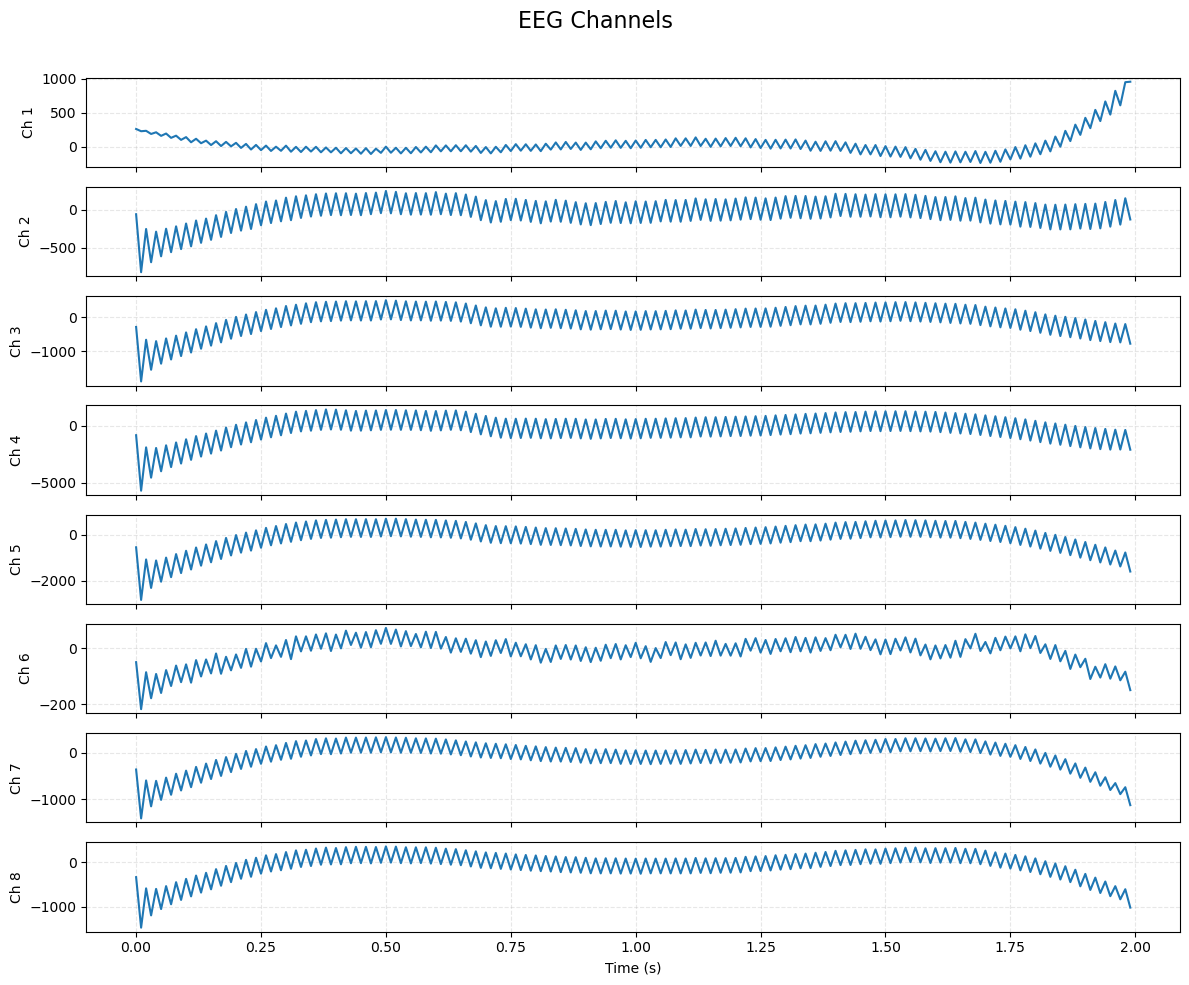

In [13]:
trial_time = np.array(preprocess_eeg_trial(train.iloc[500, :], use_case='time_domain', window_size_sec=2, stride_sec=0.5))
trial_preprocessed_time = preprocess_time_domain(trial_time[1], fs=250, lowcut=1, highcut=45, downsample_to=100, clip_thresh=None)[0]
plot_eeg_channels(trial_preprocessed_time, fs=100)

In [14]:
def preprocess_frequency_domain(eeg_data, fs=250, lowcut=1, highcut=45, downsample_to=None, clip_thresh=None):
    """
    Preprocess EEG data for frequency-domain analysis (e.g., bandpower).
    """
    eeg = remove_dc_offset(eeg_data)
    eeg = bandpass_filter(eeg, lowcut, highcut, fs)
    if clip_thresh is not None:
        eeg = clip_extremes(eeg, threshold=clip_thresh)

    # Keep original scale (no standardization), useful for power analysis
    if downsample_to is not None and downsample_to < fs:
        num_samples = int(eeg.shape[1] * downsample_to / fs)
        eeg = signal.resample(eeg, num_samples, axis=1)
        fs = downsample_to

    return eeg, fs

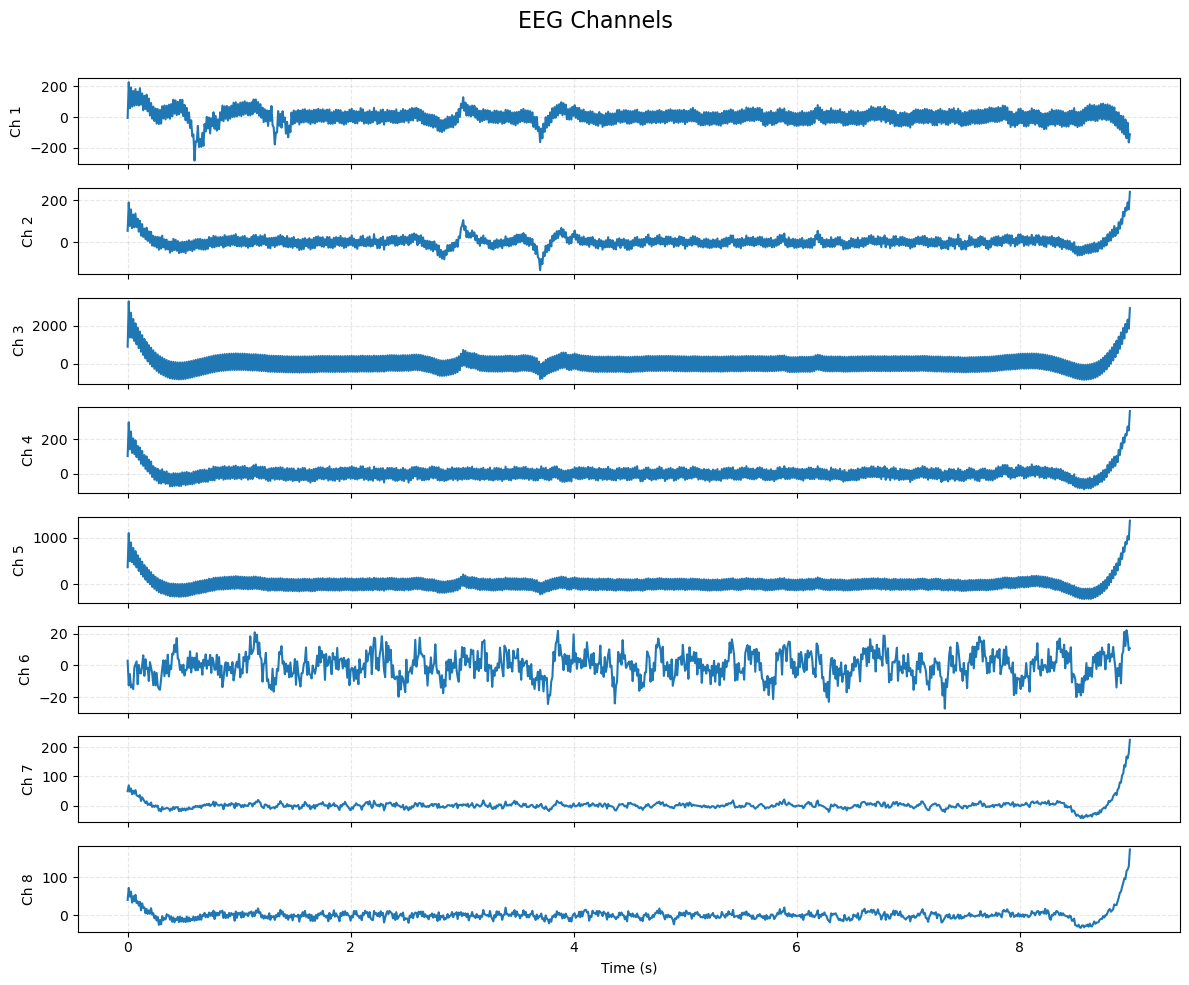

In [15]:
trial_freq = np.array(preprocess_eeg_trial(train.iloc[1, :], use_case='frequency_domain', interpolation_kind='nearest'))
trial_preprocessed_freq = preprocess_frequency_domain(trial_freq, fs=250, lowcut=1, highcut=45, downsample_to=100, clip_thresh=None)[0]
plot_eeg_channels(trial_preprocessed_freq, fs=100)

In [16]:
def preprocess_deep_learning(eeg_data, fs=250, lowcut=1, highcut=45, clip_thresh=None):
    """
    Preprocess EEG data for deep learning (e.g., CNN, RNN).
    """
    eeg = remove_dc_offset(eeg_data)
    eeg = bandpass_filter(eeg, lowcut, highcut, fs)
    if clip_thresh is not None:
        eeg = clip_extremes(eeg, threshold=clip_thresh)
    eeg = standardize(eeg)  # required for DL models

    # (optional) augmentation and segmentation can be added later
    return eeg, fs

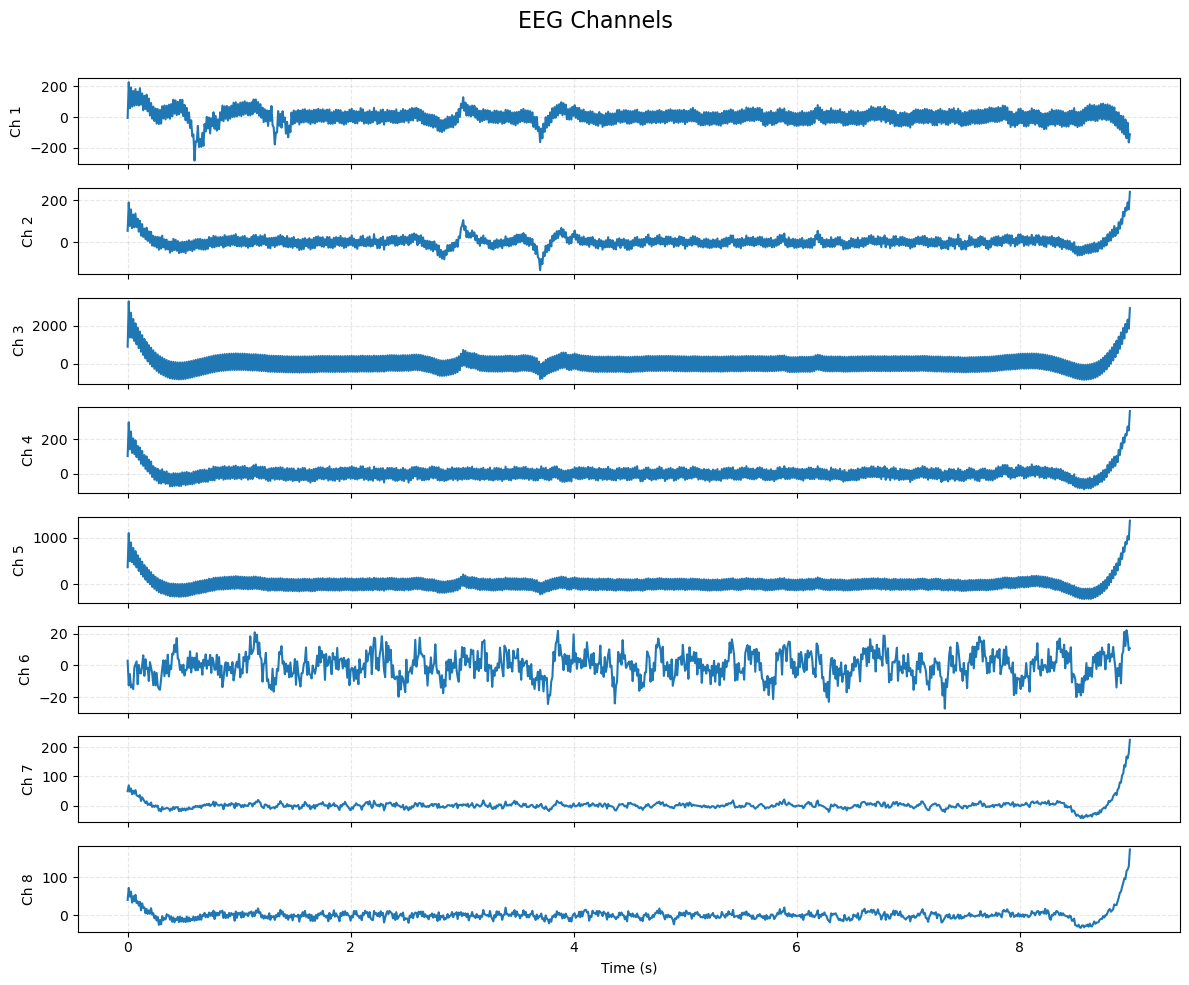

In [17]:
trial_deep = np.array(preprocess_eeg_trial(train.iloc[200, :], use_case='deep_learning', interpolation_kind='nearest')[0])
trial_preprocessed_deep = preprocess_frequency_domain(trial_deep, fs=250, lowcut=1, highcut=45, downsample_to=100, clip_thresh=10)[0]
plot_eeg_channels(trial_preprocessed_freq, fs=100)

In [18]:
def preprocess_eeg_with_mne_time_domain(
    row,
    fs=250,
    window_size_sec=2.0,
    stride_sec=0.5,
    ch_names=None,
    l_freq=1.,
    h_freq=45.,
    notch_freq=50.,
    resample_to=None,
    max_bad_ratio=0.2,
    zscore=True,
    high_amp_thresh=5.0,  # in standard deviations
):
    dataset = get_dataset_split(row['id'])
    eeg_data = load_trial(row, dataset, base_path)
    bad_mask = get_bad_mask(eeg_data)
    eeg = eeg_data.iloc[:, 1:9].values.T

    # Interpolate bad samples
    eeg_cleaned = eeg.copy()
    for ch in range(eeg.shape[0]):
        good_idx = ~bad_mask
        if good_idx.sum() < 2:
            eeg_cleaned[ch] = 0.
        else:
            interp = interpolate.interp1d(
                np.flatnonzero(good_idx),
                eeg[ch, good_idx],
                kind='linear',
                fill_value='extrapolate'
            )
            eeg_cleaned[ch] = interp(np.arange(eeg.shape[1]))

    if ch_names is None:
        ch_names = [f"Ch{i+1}" for i in range(eeg.shape[0])]
    info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types='eeg')
    raw = mne.io.RawArray(eeg_cleaned, info)

    raw.set_eeg_reference('average')
    raw.notch_filter(freqs=notch_freq)
    raw.filter(l_freq=l_freq, h_freq=h_freq)
    if resample_to:
        raw.resample(resample_to)
    final_fs = int(raw.info['sfreq'])

    eeg_proc = raw.get_data()

    # Remove high-amplitude artifacts
    stds = np.std(eeg_proc, axis=1, keepdims=True)
    too_high = np.abs(eeg_proc) > (high_amp_thresh * stds)
    eeg_proc[too_high] = 0.0

    # Z-score normalization
    if zscore:
        means = np.mean(eeg_proc, axis=1, keepdims=True)
        stds = np.std(eeg_proc, axis=1, keepdims=True)
        eeg_proc = (eeg_proc - means) / stds

    if resample_to:
        bad_mask = signal.resample(bad_mask.astype(float), eeg_proc.shape[1]) > 0.5

    win_len = int(window_size_sec * final_fs)
    stride_len = int(stride_sec * final_fs)
    n_samples = eeg_proc.shape[1]
    windows = []

    for start in range(0, n_samples - win_len + 1, stride_len):
        end = start + win_len
        if bad_mask[start:end].mean() <= max_bad_ratio:
            windows.append(eeg_proc[:, start:end])

    return np.stack(windows), final_fs

In [19]:
preprocess_eeg_with_mne_time_domain(train.iloc[50, :], fs=250, window_size_sec=2.0, stride_sec=2.0, ch_names=None, l_freq=1., h_freq=45., notch_freq=50., resample_to=100, max_bad_ratio=0.1)[0].shape

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Wind

(2, 8, 200)

In [20]:
def preprocess_eeg_with_mne_freq_domain(
    row,
    fs=250,
    window_size_sec=2.0,
    stride_sec=0.5,
    ch_names=None,
    l_freq=1.,
    h_freq=45.,
    notch_freq=50.,
    resample_to=None,
    max_bad_ratio=0.2,
    spec_fn='welch',
    nperseg=128,
    zscore=True,
    high_amp_thresh=5.0,
):
    dataset = get_dataset_split(row['id'])
    eeg_data = load_trial(row, dataset, base_path)
    bad_mask = get_bad_mask(eeg_data)
    eeg = eeg_data.iloc[:, 1:9].values.T

    eeg_cleaned = eeg.copy()
    for ch in range(eeg.shape[0]):
        good_idx = ~bad_mask
        interp = interpolate.interp1d(
            np.flatnonzero(good_idx),
            eeg[ch, good_idx],
            kind='linear',
            fill_value='extrapolate'
        )
        eeg_cleaned[ch] = interp(np.arange(eeg.shape[1]))

    if ch_names is None:
        ch_names = [f"Ch{i+1}" for i in range(eeg.shape[0])]
    info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types='eeg')
    raw = mne.io.RawArray(eeg_cleaned, info)

    raw.set_eeg_reference('average')
    raw.notch_filter(freqs=notch_freq)
    raw.filter(l_freq=l_freq, h_freq=h_freq)
    if resample_to:
        raw.resample(resample_to)
    final_fs = int(raw.info['sfreq'])

    eeg_proc = raw.get_data()
    total_samples = eeg_proc.shape[1]

    if resample_to:
        t_old = np.linspace(0, 1, bad_mask.shape[0])
        t_new = np.linspace(0, 1, total_samples)
        bad_mask = np.interp(t_new, t_old, bad_mask).round().astype(bool)

    # High amplitude removal
    stds = np.std(eeg_proc, axis=1, keepdims=True)
    too_high = np.abs(eeg_proc) > (high_amp_thresh * stds)
    eeg_proc[too_high] = 0.0

    # Z-score scaling
    if zscore:
        means = np.mean(eeg_proc, axis=1, keepdims=True)
        stds = np.std(eeg_proc, axis=1, keepdims=True)
        eeg_proc = (eeg_proc - means) / stds

    win_len = int(window_size_sec * final_fs)
    stride_len = int(stride_sec * final_fs)
    features = []
    valid_freqs = None

    for start in range(0, total_samples - win_len + 1, stride_len):
        end = start + win_len
        if bad_mask[start:end].mean() > max_bad_ratio:
            continue
        segment = eeg_proc[:, start:end]

        if spec_fn == 'welch':
            f, Pxx = signal.welch(segment, fs=final_fs, nperseg=nperseg, axis=-1)
        elif spec_fn == 'stft':
            f, _, Zxx = signal.stft(segment, fs=final_fs, nperseg=nperseg, axis=-1)
            Pxx = np.abs(Zxx) ** 2
        else:
            raise ValueError("spec_fn must be 'welch' or 'stft'")

        features.append(Pxx)
        if valid_freqs is None:
            valid_freqs = f

    return np.stack(features), valid_freqs, final_fs

In [21]:
preprocess_eeg_with_mne_freq_domain(train.iloc[50, :], fs=250, window_size_sec=2.0, stride_sec=0.5, ch_names=None, l_freq=12., h_freq=60., notch_freq=50., resample_to=130, max_bad_ratio=0.1, spec_fn='stft')[0].shape

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 12 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Win

(9, 8, 65, 6)